# 2D Hydro simulation with Volume penalization method
This notebook aims to show the workflow of setting up aπ Hydro simulation with Volume penalization method in the cylindrical coordinates. ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X))

We pick the classical Taylor Couette experiment in low Re $(Re\sim 1)$ with the comparsion between the analytical and numerical result.

In [1]:
using MHDFlows,PyPlot,CUDA
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/2BZya/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
#parameters
N = 128;
Nz= 4;
Lx = 2π;
ν,η = 1,1;
dt = 2e-4;
# Testing the problem 
nothingfunction(args...) = nothing;
CPUprob = Problem(CPU();
        # Numerical parameters
                      nx = N,
                      Lx = 2π,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # VP method
              VP_method = true,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: ON
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on CPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [4]:
function Taylor_Couette_Cylindrical_Mask_Function(grid;R₂=0.82π,R₁=0.32π)
    nx,ny,nz = grid.nx,grid.ny,grid.nz;
    x,y,z = grid.x,grid.y,grid.z;
    S = BitArray(undef, nx,ny,nz);
    
    for k ∈ 1:nz, j ∈ 1:ny,i ∈ 1:nx
        xᵢ,yᵢ,zᵢ = x[i],y[j],z[k];
        Rᵢ       = √(xᵢ^2+yᵢ^2);
        # S = 0 if inside fluid domain while S = 1 in the solid domain 
        S[i,j,k] = (R₂ >= Rᵢ >= R₁) ?  0 : 1; 
    end    
    S
end

Taylor_Couette_Cylindrical_Mask_Function (generic function with 1 method)

In [5]:
function ProblemGeneratorTC!(prob;L0=2π,T=Float32)

  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  ux,uy,uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  Ux,Uy,Uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);  
  V₀ = 1;
  r₀ = 0.32π;  
    
  # Setup: Uθ = 1 if r ∈ 0.32π
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j; 
  prob.vars  
  χ =  Taylor_Couette_Cylindrical_Mask_Function(prob.grid;R₂=0.82π,R₁=r₀)
  for k ∈ 1:nz,j ∈ 1:ny,i ∈ 1:nx
    r = sqrt(x[i]^2+y[j]^2);
    θ = atan(y[j],x[i]) ;
    θ = isnan(θ) ? π/2 : θ
    sinθ = sin(θ);
    cosθ = cos(θ);
    #sinθ =  θ < 0 ? sin(-θ) : sin(θ)    
    if r <= r₀
        Ux[i,j,k] = -sinθ*r/r₀
        Uy[i,j,k] =  cosθ*r/r₀
    end
        
  end
    
  copyto!(prob.vars.ux, deepcopy(ux));
  copyto!(prob.vars.uy, deepcopy(uy));
  copyto!(prob.vars.uz, deepcopy(uz));
  
    
  copyto!(prob.params.χ, χ);
  copyto!(prob.params.U₀x, Ux);
  copyto!(prob.params.U₀y, Uy);  
  copyto!(prob.params.U₀z, Uz);
    
  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
      
  return nothing
end

ProblemGeneratorTC! (generic function with 1 method)

In [6]:
# Setting up the Initial condition for both domain
ProblemGeneratorTC!(CPUprob);
Ux,Uy = CPUprob.params.U₀x,CPUprob.params.U₀y;
Ur,Uθ = xy_to_polar(Ux,Uy);

## The Solid Domain and Initial condition illustration

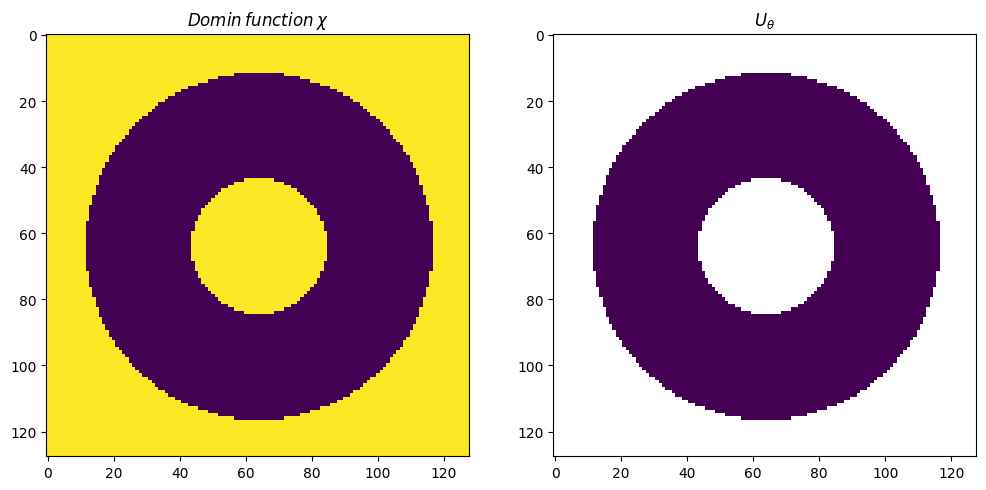

In [7]:
A  = ones(size(Ux));
χ = CPUprob.params.χ;
A[χ.==1].=NaN;
figure(figsize=(12,6))
subplot(121);
imshow(χ[:,:,1]);
title(L"Domin\:function\:\chi");
subplot(122);
imshow((A.*Uθ)[:,:,1]);
title(L"U_\theta");

In [8]:
# Set up the initial condition
TimeIntegrator!(CPUprob,5.0,50000;
                   usr_dt = dt,
                    diags = [],
              loop_number = 500,
                     save = false,
                 save_loc = "",
                 filename = "",
                  dump_dt = 0)

n =      500, t =      0.1, KE =    0.523
n =     1000, t =      0.2, KE =    0.615
n =     1500, t =      0.3, KE =    0.682
n =     2000, t =      0.4, KE =    0.731
n =     2500, t =      0.5, KE =    0.766
n =     3000, t =      0.6, KE =    0.792
n =     3500, t =      0.7, KE =    0.809
n =     4000, t =      0.8, KE =    0.821
n =     4500, t =      0.9, KE =    0.829
n =     5000, t =      1.0, KE =    0.835
n =     5500, t =      1.1, KE =    0.838
n =     6000, t =      1.2, KE =    0.841
n =     6500, t =      1.3, KE =    0.843
n =     7000, t =      1.4, KE =    0.844
n =     7500, t =      1.5, KE =    0.844
n =     8000, t =      1.6, KE =    0.845
n =     8500, t =      1.7, KE =    0.845
n =     9000, t =      1.8, KE =    0.845
n =     9500, t =      1.9, KE =    0.846
n =    10000, t =      2.0, KE =    0.846
n =    10500, t =      2.1, KE =    0.846
n =    11000, t =      2.2, KE =    0.846
n =    11500, t =      2.3, KE =    0.846
n =    12000, t =      2.4, KE =  

# Comparsion Between Numerical & Analytical Soultion 

In [11]:
function TCFlowSolution(L,N;R₁ = 0.32*π, R₂ = 0.95π, Ω₁ = 1, Ω₂ = 0)
    dev  = CPU();
    Lx = Ly = L;
    nx = ny = N;
    T  = Float32;
    grid = TwoDGrid(dev, nx, Lx, ny, Ly; T=T)
    Uθ = zeros(nx,ny)
    for j ∈ 1:ny, i ∈ 1:nx
        r = sqrt(grid.x[i]^2+grid.y[j]^2);
        Uθ[i,j] = (Ω₂*R₂^2 - Ω₁*R₁^2)/(R₂^2-R₁^2)*r + ((Ω₁-Ω₂)*R₁^2*R₂^2)/(R₂^2-R₁^2)/r
    end
    return Uθ    
end

TCFlowSolution (generic function with 1 method)

In [56]:
function xy_to_polar_(ux,uy;Lx=2π,Ly=Lx,T=Float32)   
  nx,ny,nz = size(ux);  
  dev = CPU();
  grid = TwoDGrid(dev, nx, Lx, ny, Ly; T=T)
  Ur,Uθ = xy_to_polar_(ux,uy,grid;Lx=2π,Ly=Lx,T=Float32);
  return Ur,Uθ;
end

function xy_to_polar_(ux::Array,uy::Array,grid;Lx=2π,Ly=Lx,T=Float32)
#=
  Function for converting x-y vector to r-θ vector, using linear transform
    [x']  =  [cos(θ) -rsin(θ)][r']
    [y']     [sin(θ)  rcos(θ)][θ']
    So e_r =  cosθ ̂i + sinθ ̂j
       e_θ = -sinθ ̂j + cosθ ̂j
=#    
  nx,ny,nz = size(ux);
  Ur = zeros(T,nx,ny,nz);
  Uθ = zeros(T,nx,ny,nz);
  for j ∈ 1:ny, i ∈ 1:nx
    r = sqrt(grid.x[i]^2+grid.y[j]^2);
    θ = atan(grid.y[j],grid.x[i]) ;
    θ = isnan(θ) ? π/2 : θ;
    sinθ = sin(θ);
    cosθ = cos(θ);    
    Uθ[i,j,:] .= @. -sinθ*ux[i,j,:] + cosθ*uy[i,j,:];    
    Ur[i,j,:] .= @.  cosθ*ux[i,j,:] + sinθ*uy[i,j,:];    
  end
  return Ur,Uθ;
end

xy_to_polar_ (generic function with 2 methods)

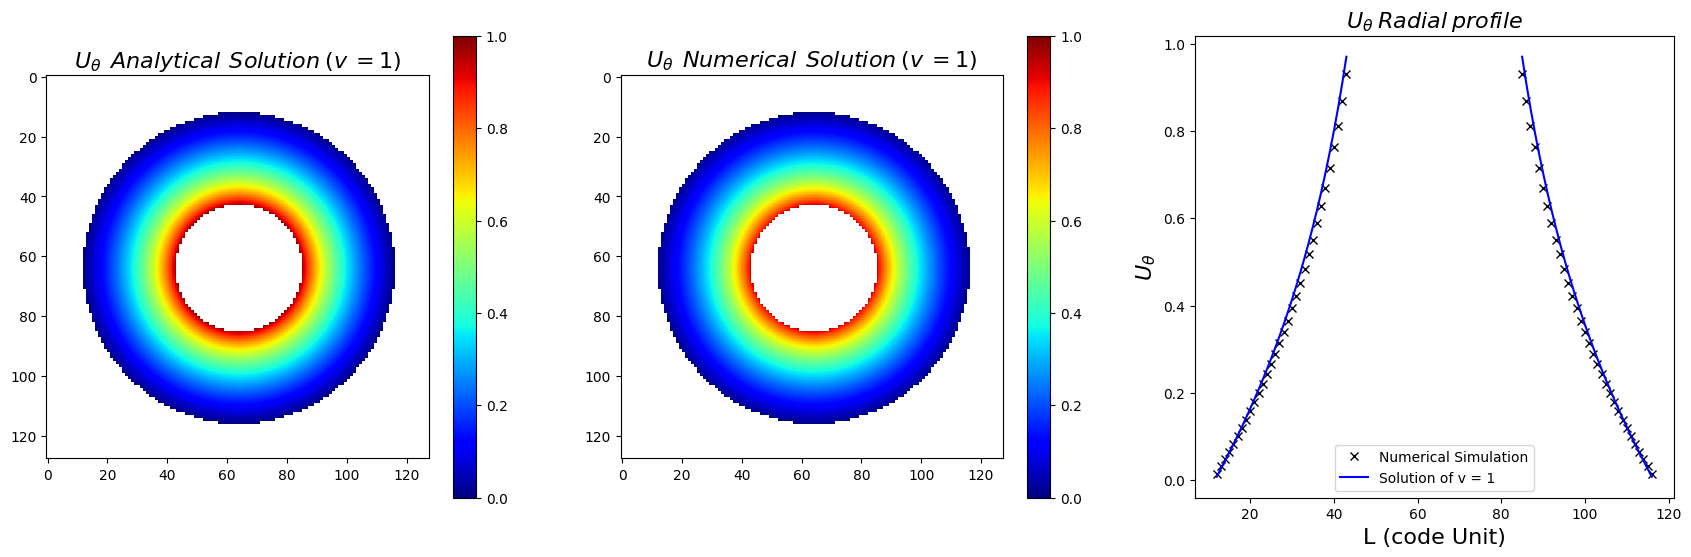

PyObject <matplotlib.legend.Legend object at 0x7fa917a8cac8>

In [62]:
figure(figsize=(21,6))
A  = ones(size(Ux));
A  = ones(size(Ux));
χ = CPUprob.params.χ;
A[χ.==1].=NaN;
subplot(131)
title(L"U_\theta\:\:Analytical\:\:Solution\:(v\:= 1)",size=16)
Lx,nx = 2π,128;
TA = TCFlowSolution(Lx,nx;R₁ = 0.32*π, R₂ = 0.82π, Ω₁ = 1, Ω₂ = 0)
TA = (A[:,:,1]).*TA;
imshow(TA,cmap="jet",vmin=0,vmax=1);colorbar()


subplot(132)
title(L"U_\theta\:\:Numerical\:\:Solution\:(v\:= 1)",size=16)
Ux,Uy = CPUprob.vars.ux,CPUprob.vars.uy;
Ur,Uθ = xy_to_polar_(Ux,Uy);
TN = (A.*Uθ)[:,:,1];
imshow(TN,cmap="jet",vmin=0,vmax=1);colorbar()


subplot(133)
AA = (A.*TA);
NN = (A.*TN);
title(L"U_\theta\:Radial\:profile",size=16)
plot(NN[:,64,1],"kx",label="Numerical Simulation")
plot(AA[:,64,1],"b-",label="Solution of v = 1")
xlabel("L (code Unit)",size=16)
ylabel(L"U_{\theta}",size=16)
legend()